In [1]:
!pip install -q --upgrade scikit-learn==1.4.2 nltk==3.9.1 joblib==1.4.2

In [2]:
import sklearn, nltk, joblib
print("sklearn:", sklearn.__version__)
print("nltk:", nltk.__version__)
print("joblib:", joblib.__version__)


sklearn: 1.4.2
nltk: 3.9.1
joblib: 1.4.2


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = ["test one", "another test", "more texts", "sport news"]
y = ["a", "a", "b", "b"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=200))
])
pipe.fit(X, y)
print("✅ sklearn pipeline fit OK")

✅ sklearn pipeline fit OK


In [4]:
from google.colab import files
import os, shutil

print("Please upload your cleaned dataset: newsbot_dataset.csv (the one from Notebook #1)")
uploaded = files.upload()

os.makedirs("data", exist_ok=True)
for fn in uploaded.keys():
    shutil.move(fn, f"data/{fn}")

print("File successfully moved to /data folder")
!ls -la data




Please upload your cleaned dataset: newsbot_dataset.csv (the one from Notebook #1)


Saving BBCNews.csv to BBCNews.csv
File successfully moved to /data folder
total 6248
drwxr-xr-x 2 root root    4096 Nov  1 20:22 .
drwxr-xr-x 1 root root    4096 Nov  1 20:22 ..
-rw-r--r-- 1 root root 6387544 Nov  1 20:22 BBCNews.csv


In [5]:
import pandas as pd

df = pd.read_csv("data/BBCNews.csv")
print(df.shape)
df.head(3)


(2410, 3)


,Unnamed: 0,descr,tags
0,0,chelsea sack mutu chelsea have sacked adrian ...,"sports, stamford bridge, football association,..."
1,1,record fails to lift lacklustre meet yelena i...,"sports, madrid, birmingham, france, scotland, ..."
2,2,edu describes tunnel fracas arsenals edu has ...,"sports, derby, brazil, tunnel fracasedu, food,..."


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords & punkt tokenizer if not already present
nltk.download("stopwords")
nltk.download("punkt")

EN_STOP = set(stopwords.words("english"))

# Text cleaning
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+|https\S+", " ", s)  # remove URLs
    s = re.sub(r"[^a-z\s]", " ", s)                 # remove non-letters
    s = re.sub(r"\s+", " ", s).strip()              # normalize spaces
    return s

# Tokenization + stopword removal
def preprocess_text(s: str) -> str:
    s = clean_text(s)
    tokens = word_tokenize(s)
    tokens = [t for t in tokens if t not in EN_STOP and len(t) > 2]
    return " ".join(tokens)

# Apply preprocessing
df["clean_content"] = df["descr"].astype(str).apply(preprocess_text)

print("✅ Preprocessing completed!")
df[["descr", "clean_content"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Preprocessing completed!


,descr,clean_content
0,chelsea sack mutu chelsea have sacked adrian ...,chelsea sack mutu chelsea sacked adrian mutu f...
1,record fails to lift lacklustre meet yelena i...,record fails lift lacklustre meet yelena isinb...
2,edu describes tunnel fracas arsenals edu has ...,edu describes tunnel fracas arsenals edu lifte...
3,ogara revels in ireland victory ireland flyha...,ogara revels ireland victory ireland flyhalf r...
4,unclear future for striker baros liverpool fo...,unclear future striker baros liverpool forward...


In [7]:
import re
import pandas as pd

# Starting from your current df with columns: descr, tags, clean_content
df = df.copy()
df['tags'] = df['tags'].astype(str).str.lower()

def to_bbc_cat(s: str):
    if re.search(r'\bsport', s): return 'sport'
    if re.search(r'\bbusiness', s): return 'business'
    if re.search(r'\bentertain', s): return 'entertainment'
    if re.search(r'\bpolitic', s): return 'politics'
    if re.search(r'\btech', s): return 'tech'
    return None

df['category'] = df['tags'].apply(to_bbc_cat)
df = df.dropna(subset=['category', 'clean_content']).copy()

# Keep only classes with enough samples for a stratified split
min_per_class = 15
vc = df['category'].value_counts()
keep = vc[vc >= min_per_class].index
df = df[df['category'].isin(keep)].copy()

# Cap total rows for Colab
if len(df) > 2000:
    df = df.sample(n=2000, random_state=42)

print("Counts per class:\n", df['category'].value_counts())
print("Shape:", df.shape)


Counts per class:
 category
business         512
sport            497
entertainment    392
politics         324
tech             275
Name: count, dtype: int64
Shape: (2000, 5)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_content"], df["category"], test_size=0.2,
    random_state=42, stratify=df["category"]
)

def make_pipeline(clf):
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            max_df=0.9, min_df=2, ngram_range=(1,2),
            max_features=30000, dtype=float  # reduce memory
        )),
        ("clf", clf)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=300, n_jobs=1),
    "LinearSVC": LinearSVC(),
    "MultinomialNB": MultinomialNB()
}

results = []
for name, clf in models.items():
    pipe = make_pipeline(clf)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    results.append((name, acc))
    print(f"\n🧠 {name} | Accuracy: {acc:.3f}")
    print(classification_report(y_test, pred, zero_division=0, digits=3))

sorted(results, key=lambda x: x[1], reverse=True)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'float'> 'dtype' will be converted to np.float64.
  warnings.warn(



🧠 LogisticRegression | Accuracy: 0.948
               precision    recall  f1-score   support

     business      0.931     0.931     0.931       102
entertainment      0.961     0.936     0.948        78
     politics      0.909     0.923     0.916        65
        sport      0.980     0.970     0.975       100
         tech      0.947     0.982     0.964        55

     accuracy                          0.948       400
    macro avg      0.946     0.948     0.947       400
 weighted avg      0.948     0.948     0.948       400



/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'float'> 'dtype' will be converted to np.float64.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



🧠 LinearSVC | Accuracy: 0.960
               precision    recall  f1-score   support

     business      0.969     0.922     0.945       102
entertainment      0.949     0.962     0.955        78
     politics      0.913     0.969     0.940        65
        sport      0.990     0.970     0.980       100
         tech      0.965     1.000     0.982        55

     accuracy                          0.960       400
    macro avg      0.957     0.964     0.960       400
 weighted avg      0.961     0.960     0.960       400



/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'float'> 'dtype' will be converted to np.float64.
  warnings.warn(



🧠 MultinomialNB | Accuracy: 0.873
               precision    recall  f1-score   support

     business      0.714     0.931     0.809       102
entertainment      0.921     0.897     0.909        78
     politics      0.902     0.846     0.873        65
        sport      0.990     0.950     0.969       100
         tech      1.000     0.618     0.764        55

     accuracy                          0.873       400
    macro avg      0.905     0.849     0.865       400
 weighted avg      0.893     0.873     0.873       400



[('LinearSVC', 0.96),
 ('LogisticRegression', 0.9475),
 ('MultinomialNB', 0.8725)]

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:2077: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'float'> 'dtype' will be converted to np.float64.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


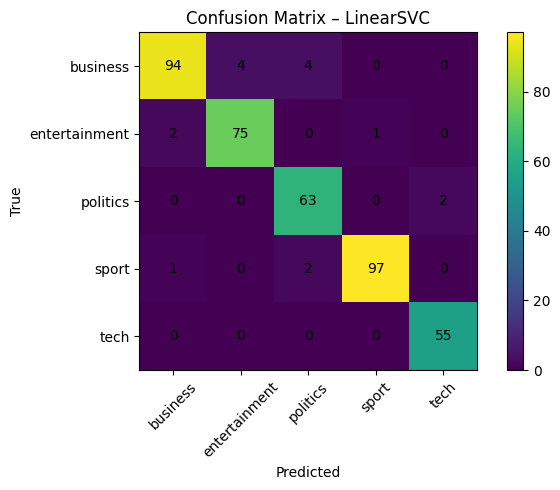

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Refit best model on the same split to get predictions for the matrix
best_name = "LinearSVC"
best_pipe = make_pipeline(LinearSVC())
best_pipe.fit(X_train, y_train)
pred_best = best_pipe.predict(X_test)

labels = sorted(df['category'].unique())
cm = confusion_matrix(y_test, pred_best, labels=labels)

plt.figure(figsize=(7,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f"Confusion Matrix – {best_name}")
plt.colorbar()
ticks = np.arange(len(labels))
plt.xticks(ticks, labels, rotation=45)
plt.yticks(ticks, labels)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [10]:
import os, joblib
from sklearn.metrics import accuracy_score, classification_report

os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/reports", exist_ok=True)

# Save model
model_path = f"outputs/models/newsbot_best_{best_name}.pkl"
joblib.dump(best_pipe, model_path)

# Save metrics
acc = accuracy_score(y_test, pred_best)
with open("outputs/reports/metrics.txt", "w") as f:
    f.write(f"Best model: {best_name}\nAccuracy: {acc:.4f}\n")
    f.write("\nClassification report:\n")
    f.write(classification_report(y_test, pred_best, zero_division=0))

# Save test predictions
pd.DataFrame({
    "content": X_test,
    "true_category": y_test.values,
    "pred_category": pred_best
}).to_csv("outputs/reports/test_predictions.csv", index=False)

print("✅ Saved:")
!ls -la outputs/models
!ls -la outputs/reports | sed -n '1,20p'


✅ Saved:
total 6548
drwxr-xr-x 2 root root    4096 Nov  1 20:27 .
drwxr-xr-x 4 root root    4096 Nov  1 20:27 ..
-rw-r--r-- 1 root root 6696573 Nov  1 20:27 newsbot_best_LinearSVC.pkl
total 632
drwxr-xr-x 2 root root   4096 Nov  1 20:27 .
drwxr-xr-x 4 root root   4096 Nov  1 20:27 ..
-rw-r--r-- 1 root root    560 Nov  1 20:27 metrics.txt
-rw-r--r-- 1 root root 631966 Nov  1 20:27 test_predictions.csv


In [11]:
def classify_article(raw_text: str) -> str:
    cleaned = preprocess_text(raw_text)  # uses your earlier function
    return best_pipe.predict([cleaned])[0]

# Try it:
sample = """Apple announced new chips focused on AI acceleration and enterprise security features."""
print("Predicted:", classify_article(sample))


Predicted: tech


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vec = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2), max_features=30000)
X_all = vec.fit_transform(df['clean_content'])
terms = np.array(vec.get_feature_names_out())

def top_terms(category, topn=12):
    idx = (df['category'] == category).values
    scores = X_all[idx].mean(axis=0).A1
    top_idx = scores.argsort()[::-1][:topn]
    return list(zip(terms[top_idx], scores[top_idx]))

for cat in sorted(df['category'].unique()):
    print(f"\nTop terms – {cat}")
    for t, s in top_terms(cat):
        print(f"{t:25s} {s:.4f}")



Top terms – business
said                      0.0399
growth                    0.0247
year                      0.0234
market                    0.0229
economy                   0.0220
sales                     0.0215
company                   0.0203
bank                      0.0196
shares                    0.0185
economic                  0.0181
firm                      0.0179
oil                       0.0173

Top terms – entertainment
film                      0.0617
music                     0.0317
best                      0.0311
said                      0.0280
films                     0.0232
show                      0.0229
awards                    0.0225
award                     0.0214
band                      0.0183
festival                  0.0175
new                       0.0173
actor                     0.0173

Top terms – politics
said                      0.0526
labour                    0.0465
election                  0.0456
blair                     0.0427
gover